In [356]:
import pennylane as qml
import jax
import jax.numpy as jnp
import flax.linen as nn
from pennylane.templates import RandomLayers
from pennylane.templates import StronglyEntanglingLayers
from pennylane.templates import BasicEntanglerLayers
import jax_dataloader as jdl
import numpy as np

In [357]:
pennylane_version = qml.__version__
print(f"Versión de PennyLane: {pennylane_version}")

Versión de PennyLane: 0.35.1


In [358]:
'''
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits,
                n_qlayers=2,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit.torch"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size #features
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget,torch_device='cuda')
        self.dev_input = qml.device(self.backend, wires=self.wires_input,torch_device='cuda')
        self.dev_update = qml.device(self.backend, wires=self.wires_update,torch_device='cuda')
        self.dev_output = qml.device(self.backend, wires=self.wires_output,torch_device='cuda')
        '''

'\n    def __init__(self, \n                input_size, \n                hidden_size, \n                n_qubits,\n                n_qlayers=2,\n                batch_first=True,\n                return_sequences=False, \n                return_state=False,\n                backend="default.qubit.torch"):\n        super(QLSTM, self).__init__()\n        self.n_inputs = input_size #features\n        self.hidden_size = hidden_size\n        self.concat_size = self.n_inputs + self.hidden_size\n        self.n_qubits = n_qubits\n        self.n_qlayers = n_qlayers\n        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"\n\n        self.batch_first = batch_first\n        self.return_sequences = return_sequences\n        self.return_state = return_state\n\n        #self.dev = qml.device("default.qubit", wires=self.n_qubits)\n        #self.dev = qml.device(\'qiskit.basicaer\', wires=self.n_qubits)\n        #self.dev = qml.device(\'qiskit.ibm\', wires=self.n_qubits)\n  

In [359]:
class QLSTM(nn.Module):
    seq_lenght:int
    n_qlayers:int
    n_qubits:int
    hidden_size:int
    target_size:int
    
    def setup(self):
        self.weightsf=self.param('weightsf',nn.initializers.normal(),(self.n_qlayers, self.n_qubits))
        self.weightsi=self.param('weightsi',nn.initializers.normal(),(self.n_qlayers, self.n_qubits))
        self.weightsu=self.param('weightsu',nn.initializers.normal(),(self.n_qlayers, self.n_qubits))
        self.weightso=self.param('weightso',nn.initializers.normal(),(self.n_qlayers, self.n_qubits))
    def circuit_forget(self,inputs,weights):
        device = qml.device('default.qubit')
        wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        #self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        #self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        #self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]
        @qml.qnode(device=device)
        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=wires_forget)
            pesos=weights[0,:]
            pesos=pesos.reshape(1,-1)
            qml.templates.BasicEntanglerLayers(pesos, wires=wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires_forget]
        _circuit_forget=jax.jit(_circuit_forget)
        out=_circuit_forget(inputs,weights)
        return out
    
    def circuit_input(self,inputs,weights):
        wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        device = qml.device('default.qubit')
        @qml.qnode(device=device)
        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=wires_input)
            pesos=weights[0,:]
            pesos=pesos.reshape(1,-1)
            qml.templates.BasicEntanglerLayers(pesos, wires=wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires_input]
        _circuit_input=jax.jit(_circuit_input)
        out=_circuit_input(inputs,weights)
        return out
    
    def circuit_update(self,inputs,weights):
        wires_update = [f"wire_input_{i}" for i in range(self.n_qubits)]
        device = qml.device('default.qubit')
        @qml.qnode(device=device)
        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=wires_update)
            pesos=weights[0,:]
            pesos=pesos.reshape(1,-1)
            qml.templates.BasicEntanglerLayers(pesos, wires=wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires_update]
        _circuit_update=jax.jit(_circuit_update)
        out=_circuit_update(inputs,weights)
        return out
    def circuit_output(self,inputs,weights):
        wires_output = [f"wire_input_{i}" for i in range(self.n_qubits)]
        device = qml.device('default.qubit')
        @qml.qnode(device=device)
        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=wires_output)
            pesos=weights[0,:]
            pesos=pesos.reshape(1,-1)
            qml.templates.BasicEntanglerLayers(pesos, wires=wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in wires_output]
        _circuit_output=jax.jit(_circuit_output)
        out=_circuit_output(inputs,weights)
        return out
    
    @nn.compact
    def __call__(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
       
        hidden_seq = []
        batch_size=16
        if init_states is None:
            h_t = jnp.zeros((batch_size, self.hidden_size))  # hidden state (output)
            c_t = jnp.zeros((batch_size, self.hidden_size)) # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(self.seq_lenght):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :] #x has shape (batch,seq_len,features)
            
            # Concatenate input and hidden state
            v_t = jnp.concatenate((h_t, x_t), axis=1)
            #print('el shape de vt',v_t.shape)
            # match qubit dimension
            y_t = nn.Dense(self.n_qubits)(v_t) #Dense gives an output of n_qubits
            #print('el shape de yt',y_t.shape)
            f_t=self.circuit_forget(y_t,self.weightsf)
            f_t=jnp.asarray(f_t)
            f_t = nn.sigmoid(f_t)  # forget block
            #print('el shape de ft antes del dense',f_t.shape)
            f_t=jnp.transpose(f_t)
            f_t=nn.Dense(self.hidden_size)(f_t)
            #print('el shape de f_t',f_t.shape)
            i_t = self.circuit_input(y_t,self.weightsi)  # input block
            i_t=jnp.asarray(i_t)
            i_t=nn.sigmoid(i_t)
            i_t=jnp.transpose(i_t)
            i_t=nn.Dense(self.hidden_size)(i_t)
            #print('el shape de i_t',i_t.shape)
            g_t = self.circuit_update(y_t,self.weightsu) # update block
            g_t=jnp.asarray(g_t)
            g_t=jnp.tanh(g_t)
            g_t=jnp.transpose(g_t)
            g_t=nn.Dense(self.hidden_size)(g_t)
            #print('el shape de g_t',g_t.shape)
            o_t = self.circuit_output(y_t,self.weightso)# output block
            o_t=jnp.asarray(o_t)
            o_t=nn.sigmoid(o_t)
            o_t=jnp.transpose(o_t)
            o_t=nn.Dense(self.hidden_size)(o_t)
            #print('el shape de o_t',o_t.shape)
            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * nn.tanh(c_t) #it has size (batch_size, hidden)
            hidden_seq.append(jnp.expand_dims(h_t, axis=0))#we will end with a number of sequences of the size of the window of time 
                                 
        hidden_seq = jnp.concatenate(hidden_seq, axis=0) #(window, batch_size,hidden)
        print('el shape de hiddenseq',hidden_seq.shape)
        hidden_seq = hidden_seq.transpose(1, 0, 2)  #(batch_size,window,hidden)
        print('el shape de hiddenseq despues',hidden_seq.shape)
        hidden_seq=hidden_seq[:, -1, :]
        target=nn.Dense(self.target_size)(hidden_seq)
        return target

Classic architectureee (only to verify which dimensions we should have)
==

In [360]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import r2_score

#from qlstm_pennylane import QLSTM



In [361]:
# Verificar si hay una GPU disponible y establecer el dispositivo

df = pd.read_csv('BTC_1m_210601_230126.csv')
data_btc = df.iloc[:, 1:6].values

In [362]:
data_btc_30min = np.reshape(data_btc, (29024, 30, 5))
data_btc_open = data_btc_30min[:,0,0]
data_btc_close = data_btc_30min[:,29,3]
data_btc_high = np.amax(data_btc_30min[:,:,1], axis=1)
data_btc_low = np.amin(data_btc_30min[:,:,2], axis=1)
data_btc_volume = np.sum(data_btc_30min[:,:,4], axis=1)
data_btc_30min = np.concatenate((data_btc_open[:,None], data_btc_high[:,None], data_btc_low[:,None], data_btc_close[:,None], data_btc_volume[:,None]), axis=1)

In [363]:
data_btc_30min=data_btc_30min[0:5000,:]

In [364]:
scaler = MinMaxScaler()
scaled_data_btc = scaler.fit_transform(data_btc_30min)

In [365]:
def create_sequences(data, sequence_length):
    sequences = []
    columna_close=3
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length:i+sequence_length+1]
        
        sequences.append((seq, label)) #el label si tiene tamaño (1,features)
    return sequences

In [366]:
#sequence_length = 4  # Longitud de la secuencia de entrada
# Create sequences and corresponding labels for training set
#sequences = create_sequences(scaled_data_btc, sequence_length)

In [367]:
data=np.genfromtxt('BTC.csv', delimiter=',',skip_header=1)
data=data[:,1:-1]
#data=np.transpose(data)
scaled_data_btc=(data-np.min(data))/(np.max(data)-np.min(data))

features=int(data.shape[0])
scaled_data = np.zeros((3760,4,6))
for t in range(4,3764):
    idx = t-4 # row index. 
    scaled_data[idx,:,:] =np.transpose([scaled_data_btc[t-4],scaled_data_btc[t-3],scaled_data_btc[t-2],
                            scaled_data_btc[t-1],scaled_data_btc[t],scaled_data_btc[t+1]])
    # We use the first 3000 points to train the model and the rest 
    # for the testing phase:
train_data = scaled_data[0:3000,:,0:6]
test_data = scaled_data[3000:,:,0:6]

In [368]:

X_train=train_data[:,:,:5]
Y_train=train_data[:,:,5]
X_test=test_data[:,:,:5]
Y_test=test_data[:,:,5]
print(Y_test.shape)
train_data = jdl.ArrayDataset(X_train, Y_train)
test_data=jdl.ArrayDataset(X_test, Y_test)
# Crear DataLoader para cargar los datos
trainloader=jdl.DataLoader(
    train_data, # Can be a jdl.Dataset or pytorch or huggingface or tensorflow dataset
    backend='jax', # Use 'jax' backend for loading data
    batch_size=16, # Batch size 
    shuffle=False, # Shuffle the dataloader every iteration or not
    drop_last=True, # Drop the last batch or not
    )
testloader=jdl.DataLoader(
test_data, # Can be a jdl.Dataset or pytorch or huggingface or tensorflow dataset
backend='jax', # Use 'jax' backend for loading data
batch_size=16, # Batch size 
shuffle=False, # Shuffle the dataloader every iteration or not
drop_last=True, # Drop the last batch or not
)

(760, 4)


In [369]:
import optax

def train_model(X_train,trainloader, seq_len,n_layers,n_qubits,concat_size,target_size,key):
    # Función de pérdida y optimizador
  
    optimizer= optax.adam(learning_rate=5e-4)
    loss_list = []
    net=QLSTM(seq_len,n_layers,n_qubits,concat_size,target_size)
    key2 = jax.random.PRNGKey(key)
    sample_input = jnp.array(X_train[:16,:,:])
    input_shape = sample_input.shape
    #input_shape = (1,) + input_shape
    
    params = net.init(key2, jnp.ones(input_shape))
    opt_state = optimizer.init(params)
    @jax.jit
    def train_step(params, opt_state, inputs, targets):
        def mse_loss(params,inputs, targets):
            predictions = net.apply(params,inputs)
            loss = jnp.mean((predictions - targets) ** 2)
            return loss
        loss, grads = jax.value_and_grad(mse_loss)(params,inputs,targets)
        #print(f"Gradients for QuanvLayer1D: {grads['QuanvLayer1D']}")
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        #print("Gradients for QuanvLayer1D:", grads)
        return params, opt_state, loss
    # Entrenamiento del modelo
    for epoch in range(30):
        epoch_loss = 0.0
        for data in trainloader:
            inputs = data[0]
            print(inputs.shape)
            targets = data[1]
            params, opt_state, loss = train_step(params, opt_state, inputs, targets)
        epoch_loss += inputs.shape[0] * loss
            
            
        epoch_loss = epoch_loss/len(X_train)
        print('[Epoch %d] loss: %.6f' % (epoch + 1, epoch_loss))


In [370]:
# Hiperparámetros
sequence_length = 4  # Longitud de la secuencia de entrada
input_size = 4      # Features
concat_size = 24     # Tamaño de la capa oculta LSTM
n_qubits=4             #
n_layers = 1      # Número de capas LSTM
target_size = 4     # Features de salida (solo es un punto)
learning_rate = 0.02
num_epochs = 50
key=0
#seed 



train_model(X_train,trainloader, sequence_length,n_layers,n_qubits,concat_size,target_size,key)

el shape de hiddenseq (4, 16, 24)
el shape de hiddenseq despues (16, 4, 24)
(16, 4, 5)
el shape de hiddenseq (4, 16, 24)
el shape de hiddenseq despues (16, 4, 24)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(16, 4, 5)
(

In [371]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.axis(ymin=0,ymax=0.00005)
plt.show()

NameError: name 'loss_list' is not defined

In [18]:
def save_model(model,name):
    #guardar el modelo
    torch.save(model.state_dict(), 'weights/'+ name + '.pth')
    

In [19]:
print(loss_list)

[0.03868192806839943, 0.027662204578518867, 0.029371080920100212, 0.029440678656101227, 0.013996921479701996, 0.013008243404328823, 0.003953524865210056, 0.0030577953439205885, 0.0005773891462013125, 0.003437589854001999, 0.0005702017806470394, 0.0010277878027409315, 0.0001984521368285641, 0.0005776617908850312, 0.00029535891371779144, 0.00033886911114677787, 0.0033949757926166058, 0.0004911402356810868, 0.00035532863694243133, 0.0008551850914955139, 0.0008071507909335196, 0.0022173405159264803, 0.0005145516479387879, 0.0011959350667893887, 0.0053375838324427605, 0.00012479035649448633, 0.0002207865472882986, 0.0004940862418152392, 9.056663839146495e-05, 0.0006155393202789128, 0.00016806667554192245, 0.00023961679835338145, 0.00015092584362719208, 0.0005285431398078799, 0.00024412162019871175, 0.0007164740818552673, 0.0006372766220010817, 0.0011838879436254501, 0.0006173268775455654, 0.0044540888629853725, 0.00030025705927982926, 9.367270831717178e-05, 7.386325887637213e-05, 7.06296341

In [20]:
#save_model(model,'cuda_lstm')

In [21]:
def predict(model, test_data):
    # Poner el modelo en modo de evaluación
    model.eval()
    # Determinar el dispositivo (CPU o GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Mover el modelo al dispositivo
    model.to(device)

    with torch.no_grad():
        test_predictions = []
        for data_point in test_data:
            test_seq = torch.FloatTensor(data_point[0]).unsqueeze(dim=0).to(device)
            prediction = model(test_seq)
            test_predictions.append(prediction)
    
    # Concatenar las predicciones y retornar
    return torch.cat(test_predictions, dim=0)


In [22]:
test_predictions= predict(model,test_data)

In [23]:
test_predictions = test_predictions.cpu()
test_predictions_np = test_predictions.numpy()

In [24]:
def plot_predictions(test_data,test_predictions):
    #reverse scaling
    test_predictions=scaler.inverse_transform(test_predictions)
    #print(test_data.shape)
    test_data=scaler.inverse_transform(np.array(test_data))
    
    plt.figure(figsize=(10, 6)) 

    #plot datos btc and test_predictions
    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), test_data[len(train_data)+sequence_length:len(scaled_data_btc),3],label='Original Values')
    plt.plot(np.arange(len(train_data)+sequence_length,len(scaled_data_btc)), test_predictions[:,3],label='Predicted Values')
    #if you can see with more detail the plot, uncomment the next line
    #plt.axis(xmin=25000, xmax=25030, ymin=0.085, ymax=0.1)

    plt.ylabel('BTC/USD')
    plt.xlabel('Time (30 min)')
    plt.title('BTC/USD Testing Phase')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    
    plt.tight_layout()
    #plt.savefig('plots_lstm/prediction_plot.png',dpi=300)
    plt.show()

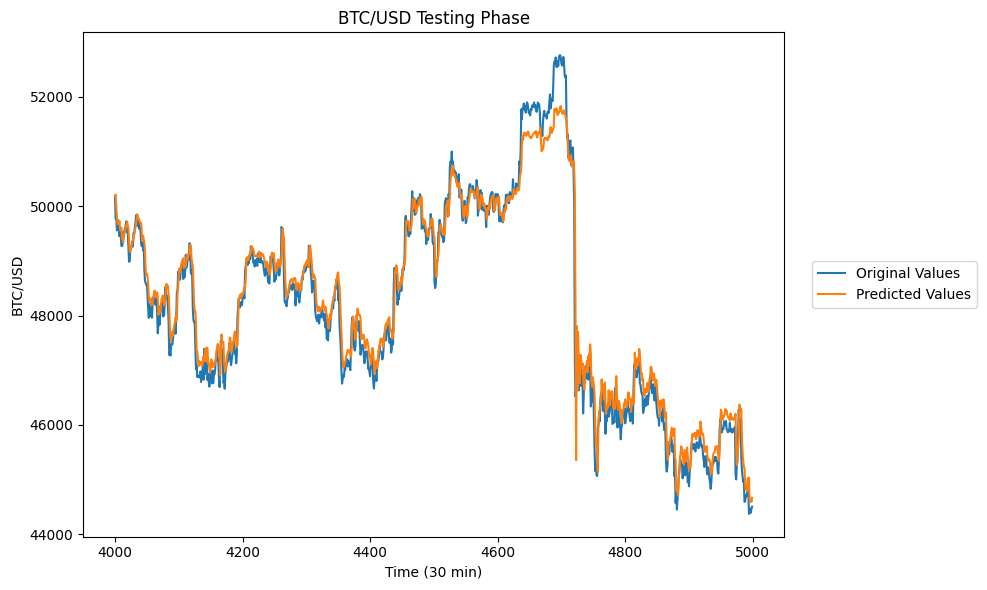

In [25]:
plot_predictions(scaled_data_btc,test_predictions)

In [26]:
def rmse(predictions, targets):
    # Assuming predictions and targets are NumPy arrays
    # Calculate the RMSE
    
    RMS = np.sqrt(np.mean(np.power((targets[len(train_data)+sequence_length:len(train_data)+sequence_length+len(predictions),3] - predictions[:,3]), 2)))
    print('RMS', RMS)
    return RMS

def rsquare(predictions, targets):
    r2 = r2_score(targets[len(train_data)+sequence_length:len(train_data)+sequence_length+len(predictions),3], predictions[:,3])
    print('r2',r2)
    return r2

In [27]:
RMS=rmse(test_predictions_np, scaled_data_btc)
r2=rsquare(test_predictions_np, scaled_data_btc)

RMS 0.014451507497419577
r2 0.9684568643993436
